# Getting Prepared

## Preparing Colab env.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!rm -R /content/sample_data

# !cd /content/drive/MyDrive/Colab\ Notebooks/CS584_NLP/Project
# !ls

This cell checks to see if we got one of the good GPUs.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a526e94a-4044-8acf-37e7-80e0e5600292)


It seems like we got Tesla P100. If not, we need to restart the session or come back sometime that that GPU is available.

## Install/Import

Here, I will install and import all the libraries and packages that we need but during the notebook I will also import them seperately right next to the code where I will use them so we get to remember and learn them better.

In [ ]:
%%capture
!pip install transformers datasets huggingface_hub
!apt install git-lfs
!git config --global user.email "homayounsadri@gmail.com"
!git config --global user.name "Homayoun Sadri"

In [ ]:
import transformers
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering
from transformers import DefaultDataCollator
from huggingface_hub import notebook_login
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback

from tensorflow.keras.callbacks import TensorBoard

import collections
import numpy as np
from tqdm.auto import tqdm


# Dataset

## Importing 

In [ ]:
squad_v2 = False
model_checkpoint = "distilbert-base-uncased" 
# model_checkpoint = "bert-base-uncased"
batch_size = 16 


In [ ]:
# from datasets import load_dataset, load_metric

datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Now let's examin the dataset.

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We have 87,599 training samples and 10,570 validation samples.

Let's take a look at one of the sampels.

In [ ]:
datasets["train"][59]

{'answers': {'answer_start': [0], 'text': ['The Lobund Institute']},
 'context': "The Lobund Institute grew out of pioneering research in germ-free-life which began in 1928. This area of research originated in a question posed by Pasteur as to whether animal life was possible without bacteria. Though others had taken up this idea, their research was short lived and inconclusive. Lobund was the first research organization to answer definitively, that such life is possible and that it can be prolonged through generations. But the objective was not merely to answer Pasteur's question but also to produce the germ free animal as a new tool for biological and medical research. This objective was reached and for years Lobund was a unique center for the study and production of germ free animals and for their use in biological and medical investigations. Today the work has spread to other universities. In the beginning it was under the Department of Biology and a program leading to the master's

# Preprocessing: Training data

Next we import our tokenizer.

In [ ]:
# from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

By instantiating our tokenizer with the `AutoTokenizer.from_pretrained` method, we ensure:

- we get a tokenizer that corresponds to the model architecture we want to use
- we download the vocabulary used when pretraining this specific checkpoint

In [ ]:
# import transformers

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

Let's see our tokenizer in action.

In [ ]:
tokenizer("Is CS584 a good class?", "You bet your ass.")

{'input_ids': [101, 2003, 20116, 27814, 2549, 1037, 2204, 2465, 1029, 102, 2017, 6655, 2115, 4632, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Something that weed to consider is the maximum length of context (where model looks for the answer). We need to truncate this to some length but we also don't want to lose the answer in the case the answer is beyind the maximum length. So we use the built-in functionality of 🤗tokenizers. We can ask the tokenizer to truncate the context into several "features" which are less than or equal maximum length in size. 
But what if an answer starts in one feature and ends in the other (i.e. doesn't compeltley fall in one of the feaures)? The tonizer can take care of this too (for the most part) with the hyper-parameter `doc_stride`. This is the overlap length between two succesicve features.

In [ ]:
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The allowed overlap between two part of the context when splitting is performed.

Next we pad our samples on the right so every sampel is of equal length which is what a keras model will expect.

In [ ]:
pad_on_right = tokenizer.padding_side == "right"

In [ ]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

Next, we use map method to apply our function to all of the data. Note that the reason we remove the column names below is that the pre-processing changes the number of samples.

In [ ]:
# # run this cell for a small dataset or the next cell for the whole dataset

# tokenized_datasets = datasets["train"].select(range(1000)).map(
#     prepare_train_features, batched=True
#     , remove_columns=datasets["train"].column_names
# )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions', 'start_positions_vec', 'end_positions_vec'],
    num_rows: 1032
})

In [ ]:
len(tokenized_datasets['input_ids'])

1032

In [ ]:
# run this cell for the whole data set

tokenized_datasets = datasets.map(
    prepare_train_features, batched=True, remove_columns=datasets["train"].column_names
)

The `batched=True` that we passed tells the tokenizer process the sampels in each batch concurrently. I.e. we are taking advantage of multi-threading capability of our "fast" tokenizer. 

Let's now see how our function does on some samples.

In [ ]:
len(prepare_train_features(datasets["train"][4:5])['input_ids'][0])

384

# Creating TensorFlow Data sets

In [ ]:
# from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
# # run this cell for small dataset or the next cell for the whole dataset

# train_set = tokenized_datasets.to_tf_dataset(
#     columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
#     shuffle=True,
#     batch_size=batch_size,
#     collate_fn=data_collator,
# )

In [ ]:
# run this cell for the whole dataset

train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
validation_set = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# Bi-LSTM

### Preparing Data for Bi-LSTM

In [ ]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    tokenized_examples["start_positions_vec"] = np.zeros( (len(tokenized_examples['input_ids']), max_length) )
    tokenized_examples["end_positions_vec"] = np.zeros( (len(tokenized_examples['input_ids']), max_length) )

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)

                tokenized_examples["start_positions_vec"][i, token_start_index - 1] = 1

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

                tokenized_examples["end_positions_vec"][i, token_end_index - 1] = 1

 
      

    return tokenized_examples

In [ ]:
# train, the whole dataset

tokenized_datasets = datasets["train"].map(
    prepare_train_features, batched=True, remove_columns=datasets["train"].column_names
)

  0%|          | 0/88 [00:00<?, ?ba/s]

In [ ]:
import tensorflow as tf
import numpy as np

ds_input_ids = np.array([np.array(xi) for xi in tokenized_datasets['input_ids']]).reshape(-1,384,1)

ds_start_positions_vec = np.array([np.array(xi) for xi in tokenized_datasets['start_positions_vec']]).reshape(-1,384,1)

ds_end_positions_vec = np.array([np.array(xi) for xi in tokenized_datasets['end_positions_vec']]).reshape(-1,384,1)


In [ ]:
# validation, the whole dataset

tokenized_datasets = datasets["validation"].map(
    prepare_train_features, batched=True, remove_columns=datasets["validation"].column_names
)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
import tensorflow as tf
import numpy as np

ds_input_ids_val = np.array([np.array(xi) for xi in tokenized_datasets['input_ids']]).reshape(-1,384,1)

ds_start_positions_vec_val = np.array([np.array(xi) for xi in tokenized_datasets['start_positions_vec']]).reshape(-1,384,1)

ds_end_positions_vec_val = np.array([np.array(xi) for xi in tokenized_datasets['end_positions_vec']]).reshape(-1,384,1)


#### scrap

In [ ]:
import tensorflow as tf
import numpy as np

ds_input_ids = tf.data.Dataset.from_tensor_slices(np.array([np.array(xi) for xi in tokenized_datasets['input_ids']]))

ds_start_positions_vec = tf.data.Dataset.from_tensor_slices(
    np.array([np.array(xi) for xi in tokenized_datasets['start_positions_vec']])) 

ds_end_positions_vec = tf.data.Dataset.from_tensor_slices(
    np.array([np.array(xi) for xi in tokenized_datasets['end_positions_vec']]))



In [ ]:
np.array(tokenized_datasets['input_ids']).shape

(1032, 384)

In [ ]:
type(np.array([np.array(xi) for xi in tokenized_datasets['input_ids']]))


numpy.ndarray

In [ ]:
type(np.array([np.array(xi) for xi in tokenized_datasets['input_ids']])[0])


numpy.ndarray

In [ ]:
np.array([np.array(xi) for xi in tokenized_datasets['input_ids']])[0]


In [ ]:
sum(tokenized_datasets['start_positions_vec'][0])

1.0

In [ ]:
len(tokenizer(datasets["train"]['question'][0:100])['input_ids'])

100

In [ ]:
len(datasets["train"]['question'][:100])

100

#### scrap

In [ ]:
train_set_temp = tokenized_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
for example in train_set_temp.take(1):
  print(ex)


{'input_ids': <tf.Tensor: shape=(16, 384), dtype=int64, numpy=
array([[ 101, 2043, 2001, ...,    0,    0,    0],
       [ 101, 2129, 2172, ...,    0,    0,    0],
       [ 101, 2054, 2024, ...,    0,    0,    0],
       ...,
       [ 101, 2054, 2003, ...,    0,    0,    0],
       [ 101, 2040, 3373, ...,    0,    0,    0],
       [ 101, 2054, 2060, ...,    0,    0,    0]])>, 'attention_mask': <tf.Tensor: shape=(16, 384), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'start_positions': <tf.Tensor: shape=(16,), dtype=int64, numpy=
array([ 58, 155,  20,  54, 187,  88,  27, 147,  22, 167,  70,  19, 133,
       157,  17, 106])>, 'end_positions': <tf.Tensor: shape=(16,), dtype=int64, numpy=
array([ 59, 157,  21,  54, 196,  95,  27, 161,  25, 168,  71,  28, 133,
       160,  20, 115])>}


In [ ]:
tokenized_dataset = tokenizer(
    datasets["train"]["question"][:1],
    # datasets["train"]["context"][:1],
    padding=True,
    truncation=True,
)

In [ ]:
datasets["train"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [ ]:
tokenized_dataset

{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
tokenized_dataset

{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2

In [ ]:
len(datasets['train']['question'])


87599

In [ ]:
datasets['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [ ]:
tokenizer(datasets['train']['question'][0])['input_ids']

[101,
 2000,
 3183,
 2106,
 1996,
 6261,
 2984,
 9382,
 3711,
 1999,
 8517,
 1999,
 10223,
 26371,
 2605,
 1029,
 102]

### Build model

In [ ]:
#Bi-LSTM encoder

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from keras.layers import Bidirectional, Concatenate

latent_dim = 256

# inputs of the encoder network
encoder_inputs = Input(shape=(max_length, 1), 
                       name='encoder_inputs')

encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
                                  dropout=0.5, name='encoder_bi-lstm'))
_, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])


# set the dense layers
encoder_dense_st = Dense(max_length, activation='sigmoid', name='encoder_dense_start')
encoder_dense_end = Dense(max_length, activation='sigmoid', name='encoder_dense_end')

encoder_outputs_st = encoder_dense_st(state_h)
encoder_outputs_end = encoder_dense_end(state_h)



# build the bi-LSTM encoder network model
encoder_bilstm_model = Model(inputs = encoder_inputs,
                             outputs =[encoder_outputs_st, encoder_outputs_end],
                             name = 'bi-LSTM_encoder')

encoder_bilstm_model.summary()

Model: "bi-LSTM_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 384, 1)]     0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  [(None, 512),       528384      ['encoder_inputs[0][0]']         
 )                               (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                    

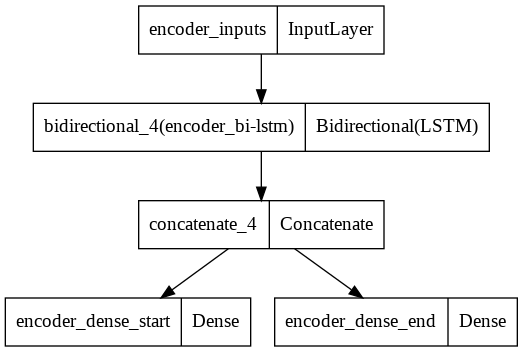

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(encoder_bilstm_model)

## Training 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# stop_early = EarlyStopping(monitor='val_loss', patience=5)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001)


In [ ]:
all_history = []
all_train_loss = []
all_val_loss = []

In [ ]:
encoder_bilstm_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                             loss='CategoricalCrossentropy')

Now, I will trian the model 4 times, each time for 10. Every time I train, the model picks up where it left off. So this is the same as 40 epochs of training. (I only compile the model once.)

In [ ]:
# using Colab Pro GPU and high RAM

history = encoder_bilstm_model.fit(ds_input_ids,  
                                    [ds_start_positions_vec, ds_end_positions_vec],                              
                                    batch_size=64, epochs=10,
                                    validation_data = [ds_input_ids_val, [ds_start_positions_vec_val, ds_end_positions_vec_val]],
                                    callbacks=[reduce_lr]
                                    )

all_history.append(history)
all_train_loss.append(history.history['loss'][0])
all_val_loss.append(history.history['val_loss'][0])

# encoder_bilstm_model.save('/content/drive/MyDrive/Colab Notebooks/CS584_NLP/Project/bilstm.h5')

Epoch 1/10
1384/1384 [==============================] - 78s 56ms/step - loss: 10.0762 - encoder_dense_start_loss: 5.0297 - encoder_dense_end_loss: 5.0465 - val_loss: 10.1445 - val_encoder_dense_start_loss: 5.0670 - val_encoder_dense_end_loss: 5.0775 - lr: 0.0010
Epoch 2/10
1384/1384 [==============================] - 79s 57ms/step - loss: 10.0524 - encoder_dense_start_loss: 5.0187 - encoder_dense_end_loss: 5.0336 - val_loss: 10.1462 - val_encoder_dense_start_loss: 5.0646 - val_encoder_dense_end_loss: 5.0816 - lr: 0.0010
Epoch 3/10
1384/1384 [==============================] - 80s 57ms/step - loss: 10.0335 - encoder_dense_start_loss: 5.0096 - encoder_dense_end_loss: 5.0239 - val_loss: 10.1763 - val_encoder_dense_start_loss: 5.0760 - val_encoder_dense_end_loss: 5.1003 - lr: 0.0010
Epoch 4/10
1384/1384 [==============================] - 79s 57ms/step - loss: 10.0236 - encoder_dense_start_loss: 5.0039 - encoder_dense_end_loss: 5.0196 - val_loss: 10.2044 - val_encoder_dense_start_loss: 5.093

In [ ]:
encoder_bilstm_model.save('bilstm_decay_epoch 40.h5')

In [ ]:
first_10_losses = all_history[0].history['loss'][:]
second_10_losses = all_history[1].history['loss'][:]

all_20_losses = first_10_losses + second_10_losses


first_10_losses_val = all_history[0].history['val_loss'][:]
second_10_losses_val = all_history[1].history['val_loss'][:]

all_20_losses_val = first_10_losses_val + first_10_losses_val


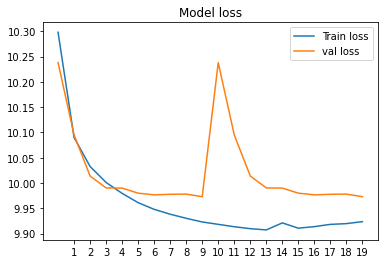

In [ ]:
import matplotlib.pyplot as plt
import math

plt.plot( range(20), all_20_losses)
plt.plot( range(20), all_20_losses_val)

plt.xticks(range(math.floor(1), math.floor(20)))

plt.legend(["Train loss", "val loss"])
plt.title('Model loss')
plt.savefig('train and val loss graph.png')
plt.show()

In [ ]:
first_10_losses = all_history[0].history['loss'][:]
second_10_losses = all_history[1].history['loss'][:]
third_10_losses = all_history[2].history['loss'][:]
fourth_10_losses = all_history[3].history['loss'][:]

all_40_losses = first_10_losses + second_10_losses + third_10_losses + fourth_10_losses


first_10_losses_val = all_history[0].history['val_loss'][:]
second_10_losses_val = all_history[1].history['val_loss'][:]
third_10_losses_val = all_history[2].history['val_loss'][:]
fourth_10_losses_val = all_history[3].history['val_loss'][:]

all_40_losses_val = first_10_losses_val + first_10_losses_val + third_10_losses_val + fourth_10_losses_val


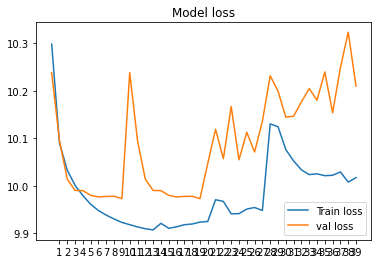

In [ ]:
plt.plot( range(40), all_40_losses)
plt.plot( range(40), all_40_losses_val)

plt.xticks(range(math.floor(1), math.floor(40)))

plt.legend(["Train loss", "val loss"])
plt.title('Model loss')
plt.savefig('train and val loss graph.png')
plt.show()

In [ ]:
# no_day_all_train_loss = all_train_loss[:]
# no_day_all_val_loss = all_val_loss[:]

## Predict

In [ ]:
pred = encoder_bilstm_model.predict(ds_input_ids_val)

#### scrap

In [ ]:
pred = encoder_bilstm_model.predict(ds_input_ids[:100])

In [ ]:
ds_input_ids[:100].shape

(100, 384, 1)

In [ ]:
ds_start_positions_vec[:100].shape

(100, 384, 1)

In [ ]:
pred[0].shape

(100, 384)

## Evaluation


In [ ]:
# train_features = datasets["train"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=datasets["train"].column_names,
# )

In [ ]:
val_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
# final_predictions = postprocess_qa_predictions(
#     datasets["train"],
#     train_features,
#     pred[0],                # predicted start logits
#     pred[1],                # predicted end logits 
#     )


In [ ]:
# takes 5 minutes with T4
final_predictions = postprocess_qa_predictions(
    datasets["validation"],
    val_features,
    pred[0],                # predicted start logits
    pred[1],                # predicted end logits 
    )


In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

In [ ]:
# for 40 epcohs_with learning rate decay

if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 0.07568590350047304, 'f1': 7.6025801241734765}

In [ ]:
# for 30 epcohs_with learning rate decay


{'exact_match': 0.13245033112582782, 'f1': 7.955539517379117}

In [ ]:
# for 20 epcohs_with learning rate decay

{'exact_match': 0.12298959318826869, 'f1': 6.82806765930544}

In [ ]:
# for 20 epochs without learning rate decay, loss started going up after 15 epochs.

{'exact_match': 0.27436140018921473, 'f1': 6.402175417850978}

#### scrap

In [ ]:
# run this cell for small dataset or the next cell for the whole dataset

train_features = datasets["train"].select(range(100)).map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["train"].column_names,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
len(train_features['input_ids'])

100

In [ ]:
final_predictions = postprocess_qa_predictions(
    datasets["train"].select(range(100)),
    train_features,
    pred[0],                # predicted start logits
    pred[1],                # predicted end logits 
    )


Post-processing 100 example predictions split into 100 features.


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

In [ ]:
# see how mnay features the first 100 smapesl give. 
# right now you are usign 100 in tokenizer and 100 in prediciton.
# the predicitons may have to be lie 105

In [ ]:
if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["train"].select(range(100))
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 0.0, 'f1': 6.227474617782871}

# Training transformers

Now we're ready to import the pre-trained model that we want from the transfomers library. We can take advantage of 🤗transformers librrary and import the model variation that is specifically changed to fit our specific task, here, question answering. 

In [ ]:
# from transformers import TFAutoModelForQuestionAnswering

model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_distil_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,364,418
Trainable params: 66,364,418
Non-trainable params: 0
_________________________________________________________________


What the output of the above cell says is that the head of this transformer has been removed and a head suitalbe for question answering has been added and the corresponding layers' weights have been randomly initialized and therefore the model needs training.

In [ ]:
model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-squad" 
learning_rate = 2e-5
num_train_epochs = 2
weight_decay = 0.01

We can use `create_optimizer` to create an optimizer with a learning rate schedule using a warmup phase followed by a linear decay.

In [ ]:
# from transformers import create_optimizer

# run the line below for small dataset or the next line for the whole dataset
# total_train_steps = (len(tokenized_datasets) // batch_size) * num_train_epochs


total_train_steps = (len(tokenized_datasets["train"]) // batch_size) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps,
    # min_lr_ratio = 0,                    # (float, optional, defaults to 0) — The final learning rate at the end of the linear 
                                           #  decay will be init_lr * min_lr_ratio
    weight_decay_rate = weight_decay,      # (float, optional, defaults to 0) — The weight decay to use.
    # power = 1.0                          # The power to use for PolynomialDecay.

)

In [ ]:
# import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


The output of the cell says that there is no Loss specified. Transformers in TensorFlow have their own internall loss. So Unless we specificaly pass a loss to `model.fit`, the internal loss will be used (We can also pass `None` for no loss). This loss is based on the type of the transformer. So in our case when we imported the Question Answering transfomer, the approproate loss for that task will be used.

The only thing that we need to do is to pass the labels in the columns arguemnt to `to_tf_dataset` so the model can see them.  

In [ ]:
# from transformers.keras_callbacks import PushToHubCallback
# from tensorflow.keras.callbacks import TensorBoard

push_to_hub_callback = PushToHubCallback(
    output_dir="./qa_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

tensorboard_callback = TensorBoard(log_dir="./qa_model_save/logs")

callbacks = [push_to_hub_callback,
             tensorboard_callback
             ]

model.fit(
    train_set,
    validation_data=validation_set,
    epochs=num_train_epochs,
    callbacks=callbacks,
)

Cloning https://huggingface.co/HomayounSadri/distilbert-base-uncased-finetuned-squad into local empty directory.


Epoch 1/2
5532/5532 [==============================] - 4063s 733ms/step - loss: 1.5153 - val_loss: 1.1668
Epoch 2/2
5532/5532 [==============================] - 4056s 733ms/step - loss: 0.9777 - val_loss: 1.1221


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file tf_model.h5:   0%|          | 3.34k/253M [00:00<?, ?B/s]

Upload file logs/train/events.out.tfevents.1651787869.b29e717c9aba.82.0.v2:   0%|          | 3.34k/1.49M [00:0…

Upload file logs/validation/events.out.tfevents.1651791768.b29e717c9aba.82.1.v2: 100%|##########| 350/350 [00:…

To https://huggingface.co/HomayounSadri/distilbert-base-uncased-finetuned-squad
   957e8e5..a504911  main -> main



# Evaluation

In [ ]:
n_best_size = 50

In [ ]:
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
# run this cell for small dataset or the next cell for the whole dataset

# validation_features = datasets["validation"].select(range(100)).map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=datasets["validation"].column_names,
# )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# run this cell for the whole dataset

validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
validation_dataset = validation_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
raw_predictions = model.predict(validation_dataset) 

In [ ]:
# raw_predictions : a list of two tupels 

raw_predictions[1].shape
raw_predictions[1][1]

array([-7.266931 , -7.8324804, -7.6823363, -7.692958 , -8.164439 ,
       -8.631863 , -7.7105722, -7.823462 , -8.329813 , -8.035268 ,
       -6.8184056, -7.6110272, -7.1490397, -7.7458606, -6.9669633,
       -4.580954 , -7.976135 , -8.179902 , -7.8586497, -4.8251996,
       -6.388201 , -8.152216 , -8.045818 , -8.5801525, -7.051149 ,
       -8.388668 , -8.49329  , -6.783607 , -5.16902  , -5.0334353,
       -8.217804 , -4.068653 , -5.239527 , -7.638534 , -7.907002 ,
       -3.3871825, -4.909016 , -4.689512 , -6.9240575, -6.879354 ,
       -4.917213 , -4.818468 , -7.885526 , -3.7060251, -3.944049 ,
       -4.62486  , -1.4088525,  3.592558 , -6.733217 , -8.136815 ,
       -6.144627 , -4.2431464, -3.195692 , -6.5548186, -3.5139089,
       -3.1312065, -5.1904306, -1.1582817,  7.3787065, -4.8565927,
       -7.103518 , -3.8666801, -6.132176 , -7.1070848, -7.327841 ,
       -5.7014384, -7.779006 , -6.289549 , -4.5553446, -3.0186784,
       -8.242918 , -7.445985 , -8.096195 , -7.7675014, -7.4953

In [ ]:
max_answer_length = 100

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(
    examples,
    features,
    all_start_logits,
    all_end_logits,
    n_best_size=20,
    max_answer_length=max_answer_length,
):
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[
                -1 : -n_best_size - 1 : -1
            ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    try: 
                      start_char = offset_mapping[start_index][0]
                    except:
                      print('offset_mapping[start_index] = ', offset_mapping[start_index])
                      print('start_index = ', start_index)
                      print('length of offset_mapping', len(offset_mapping))
                    try: 
                      end_char = offset_mapping[end_index][1]
                    except:
                      print('offset_mapping[end_index]', offset_mapping[end_index])
                      print('end_index', end_index)
                      print('length of offset_mapping', len(offset_mapping))
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = (
                best_answer["text"] if best_answer["score"] > min_null_score else ""
            )
            predictions[example["id"]] = answer

    return predictions

In [ ]:
# run this cell for small dataset or the next cell for the whole dataset

# final_predictions = postprocess_qa_predictions(
#     datasets["validation"].select(range(100)),
#     validation_features,
#     raw_predictions["start_logits"],
#     raw_predictions["end_logits"],
# )

In [ ]:
final_predictions = postprocess_qa_predictions(
    datasets["validation"],
    validation_features,
    raw_predictions["start_logits"],
    raw_predictions["end_logits"],
)

In [ ]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(1, final_predictions.items())

[('56be4db0acb8001400a502ec', 'Denver Broncos')]

In [ ]:
datasets["validation"][2]

{'answers': {'answer_start': [403, 355, 355],
  'text': ['Santa Clara, California',
   "Levi's Stadium",
   "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."]},
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'id': '56be4db0acb800

In [ ]:
final_predictions

OrderedDict([('56be4db0acb8001400a502ec', 'Denver Broncos'),
             ('56be4db0acb8001400a502ed', 'Carolina Panthers'),
             ('56be4db0acb8001400a502ee', "Levi's Stadium"),
             ('56be4db0acb8001400a502ef', 'Denver Broncos'),
             ('56be4db0acb8001400a502f0', 'gold'),
             ('56be8e613aeaaa14008c90d1', '"golden anniversary'),
             ('56be8e613aeaaa14008c90d2', 'February 7, 2016'),
             ('56be8e613aeaaa14008c90d3', 'American Football Conference'),
             ('56bea9923aeaaa14008c91b9', '"golden anniversary'),
             ('56bea9923aeaaa14008c91ba', 'American Football Conference'),
             ('56bea9923aeaaa14008c91bb', 'February 7, 2016'),
             ('56beace93aeaaa14008c91df', 'Denver Broncos'),
             ('56beace93aeaaa14008c91e0', "Levi's Stadium"),
             ('56beace93aeaaa14008c91e1', 'Santa Clara, California'),
             ('56beace93aeaaa14008c91e2', 'Super Bowl L'),
             ('56beace93aeaaa14008c91e3', '

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

In [ ]:
# run this cell for small dataset or the next cell for the whole dataset

# if squad_v2:
#     formatted_predictions = [
#         {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
#         for k, v in final_predictions.items()
#     ]
# else:
#     formatted_predictions = [
#         {"id": k, "prediction_text": v} for k, v in final_predictions.items()
#     ]
# references = [
#     {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"].select(range(100))
# ]
# metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 62.0, 'f1': 71.00294117647059}

In [ ]:
# run this cell the whole dataset

if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 74.84389782403028, 'f1': 83.77025208716542}

### Plotting losses

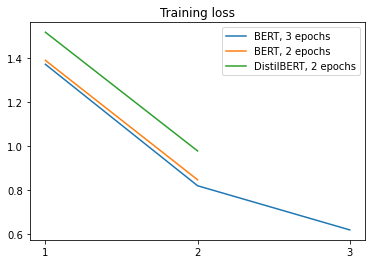

In [ ]:
import matplotlib.pyplot as plt
import math

# 1. BERT, 3 epochs
# 2. BERT, 2 epochs
# 3. DistilBERT, 2 epochs

x1 = [1, 2, 3]
y1 = [1.37, 0.82, 0.62]

x2 = [1, 2]
y2 = [1.3879, 0.8470]

x3 = [1, 2]
y3 = [1.5153, 0.9777]


y1_val = [1.01, 0.99, 1.05]
y2_val = [1.0715, 1.0267]
y3_val = [1.1668, 1.1221]


plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)

plt.xticks(range(math.floor(1), math.floor(4)))

plt.legend(["BERT, 3 epochs", "BERT, 2 epochs", "DistilBERT, 2 epochs"])
plt.title('Training loss')
plt.savefig('training loss graph.png')
plt.show()


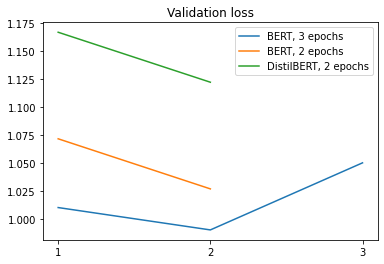

In [ ]:
plt.plot(x1, y1_val)
plt.plot(x2, y2_val)
plt.plot(x3, y3_val)

plt.xticks(range(math.floor(1), math.floor(4)))

plt.legend(["BERT, 3 epochs", "BERT, 2 epochs", "DistilBERT, 2 epochs"])
plt.title('Validation loss')
plt.savefig('validation loss graph')
plt.show()
